In [1]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import ast
import torch
import os

# Data Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
annots = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/532_object detection/images/archive/annotations.csv')

In [4]:
annots.head()

,id,image_id,geometry,class
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane


In [5]:
def tuples_to_bbox(tuples):
    x = [t[0] for t in tuples]
    y = [t[1] for t in tuples]
    return min(x), min(y), max(x), max(y)

In [6]:
annots['geometry'] = annots['geometry'].apply(ast.literal_eval)

In [7]:
annots['bbox'] = annots['geometry'].apply(tuples_to_bbox)

In [8]:
annots.head()

,id,image_id,geometry,class,bbox
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane,"(135, 522, 245, 600)"
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane,"(1025, 284, 1125, 384)"
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane,"(1058, 1503, 1130, 1568)"
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane,"(813, 1518, 885, 1604)"
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane,"(594, 938, 657, 1012)"


In [9]:
annots['class'].unique()

array(['Airplane', 'Truncated_airplane'], dtype=object)

In [10]:
#encode class to either 0 or 1
annots['class'] = annots['class'].apply(lambda x: 0 if x == 'Airplane' else 1)

In [11]:
annots.head()

,id,image_id,geometry,class,bbox
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",0,"(135, 522, 245, 600)"
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",0,"(1025, 284, 1125, 384)"
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",0,"(1058, 1503, 1130, 1568)"
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",0,"(813, 1518, 885, 1604)"
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",0,"(594, 938, 657, 1012)"


# Initializing dataset

In [12]:
#function to calculate the area of the bounding box
def bbox_area(bbox):
    return (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])


In [13]:
import pandas as pd
from PIL import Image
import torch
from torchvision.transforms import functional as F

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (pandas.DataFrame): DataFrame containing annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Group annotations by 'image_id' and aggregate data
        self.image_infos = dataframe.groupby('image_id').apply(lambda x: {
            'boxes': x['bbox'].tolist(),
            'labels': x['class'].tolist(),
            'image_id': x.name,
            'area': [bbox_area(bbox) for bbox in x['bbox']]
        }).reset_index(drop=True)

    def __len__(self):
        return len(self.image_infos)

    def __getitem__(self, idx):
        image_info = self.image_infos.iloc[idx]

        # Load image
        img_path = os.path.join(self.root_dir, image_info['image_id'])
        image = Image.open(img_path).convert("RGB")

        # Apply transformation
        if self.transform:
            image = self.transform(image)

        # Ensure image is a tensor
        if not isinstance(image, torch.Tensor):
            image = F.to_tensor(image)

        # Load bounding boxes and ensure they're in the correct shape [N, 4]
        boxes = torch.as_tensor(image_info['boxes'], dtype=torch.float32)

        # Load other required fields
        labels = torch.as_tensor(image_info['labels'], dtype=torch.int64)
        image_id = torch.tensor([idx])  # Use index as unique image ID
        area = torch.as_tensor(image_info['area'], dtype=torch.float32)

        # Construct target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id,
            'area': area
        }

        return image, target


In [14]:
# from torchvision import transforms
# from torch.utils.data import DataLoader
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

In [15]:
dataset = Dataset(annots, '/content/drive/MyDrive/Colab Notebooks/532_object detection/images/img')

In [71]:
def visualize_prediction(image, targets):
    """
    Visualize an image with bounding boxes and labels.

    Parameters:
    - image: a tensor of shape [C, H, W]
    - targets: a dictionary containing 'boxes', 'labels', 'image_id', and 'area'
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from torchvision.transforms.functional import to_pil_image

    # Convert the image tensor to a PIL Image for visualization
    image_pil = to_pil_image(image)

    # Create a Matplotlib figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(image_pil)

    # Extract boxes and labels from the targets dictionary
    boxes = targets['boxes'].cpu().numpy()  # Convert to numpy array if it's a tensor
    labels = targets['labels'].cpu().numpy()  # Convert labels to numpy array if it's a tensor

    # Iterate through the bounding boxes and labels
    for box, label in zip(boxes, labels):
        # Create a Rectangle patch for each bounding box
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Optionally, add the label next to the bounding box
        ax.text(box[0], box[1], str(label), color='blue', fontsize=12, verticalalignment='top')

    plt.show()



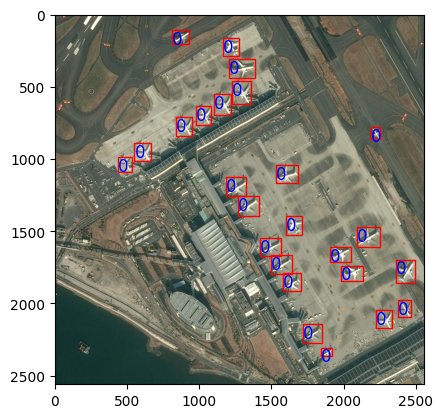

In [72]:
image, targets = dataset[15]
visualize_prediction(image, targets)

In [75]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a pre-trained model for classification and return
# only the features
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (your object) + background
# Get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [76]:
# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [77]:
from torch.utils.data.dataloader import default_collate

def collate_fn(batch):
    # Initialize containers for batched data
    images = []
    boxes = []
    labels = []
    image_ids = []
    areas = []

    for item in batch:
        images.append(item[0])  # Assuming item[0] is the image
        targets = item[1]  # Assuming item[1] contains the target dictionary
        boxes.append(targets['boxes'])
        labels.append(targets['labels'])
        image_ids.append(targets['image_id'])
        areas.append(targets['area'])

    # Stack images to a single tensor
    images = torch.stack(images, 0)

    # Now handle the list of tensors and values in targets
    # Note: PyTorch models like Faster R-CNN expect a list of dictionaries for targets, one per image
    targets = []
    for i in range(len(images)):
        targets.append({
            'boxes': boxes[i],
            'labels': labels[i].clone().detach(),
            'area': areas[i].clone().detach(),
            'image_id': torch.tensor([image_ids[i]], dtype=torch.int64)
        })

    # Now targets is a list of dictionaries, each dictionary can have tensors of different sizes
    return images, targets



In [78]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn = collate_fn)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [79]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    running_loss = 0.0

    for images, targets_batch in data_loader:
        images = [img.to(device) for img in images]

        # Move each target dict in the list of targets to the device
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets_batch]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch: {epoch}, Average Loss: {running_loss / len(data_loader)}")


In [80]:
# Training
num_epochs = 5
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, dataloader, device, epoch)
    # Here you can also save the model checkpoint if desired


Epoch: 0, Average Loss: 0.528264595912053
Epoch: 1, Average Loss: 0.24524454285319036
Epoch: 2, Average Loss: 0.17947172889342675
Epoch: 3, Average Loss: 0.15200701986367887
Epoch: 4, Average Loss: 0.13573399415382972


# Testing

In [101]:
# Load an image
import os

# Specify your directory path
directory_path = '/content/drive/MyDrive/Colab Notebooks/532_object detection/images/archive/extras'

# List all image files in the directory
image_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
def infer_image(model, image_path, device):
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)  # Add batch dimension and send to device

    # Model inference
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        prediction = model(image_tensor)

    return prediction[0]  # Return predictions for the first (and only) image


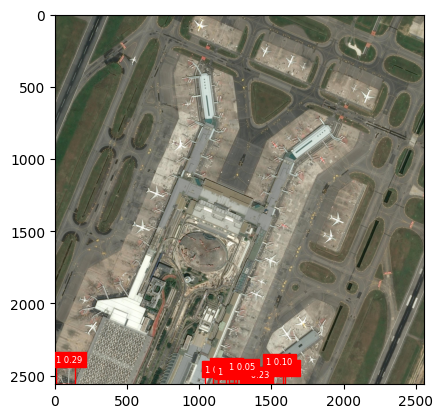

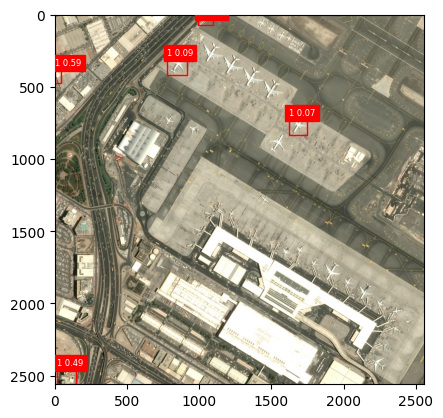

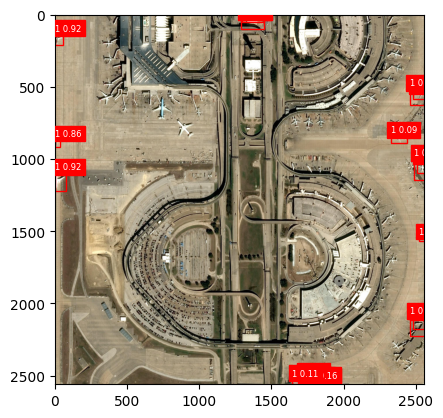

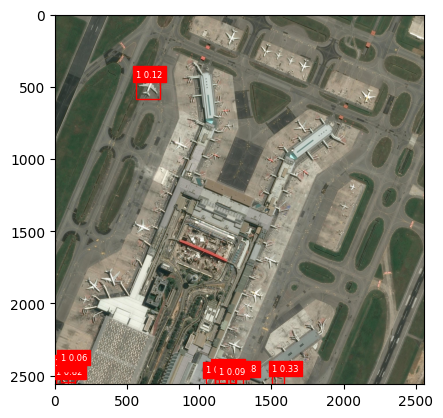

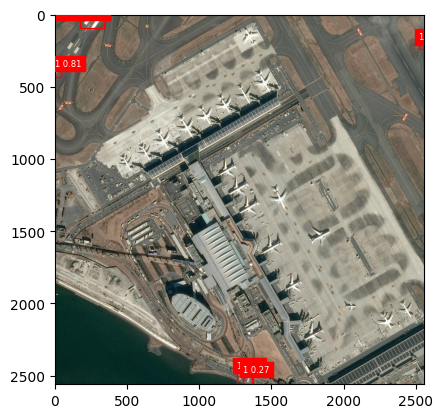

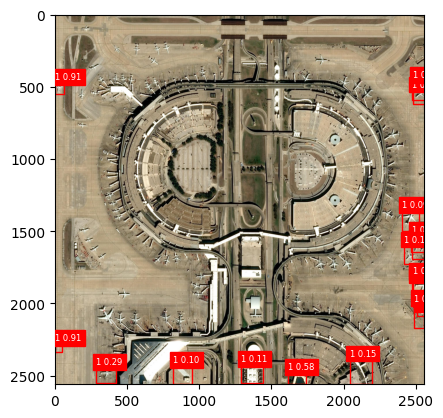

In [103]:
def visualize_predictions(image_path, prediction):
    image = Image.open(image_path)
    image_pil = F.to_pil_image(F.to_tensor(image))  # Convert image to PIL for visualization

    fig, ax = plt.subplots(1)
    ax.imshow(image_pil)

    # Set a threshold to only display predictions with confidence above this value
    threshold = 0

    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        if score > threshold:
            box = box.cpu().numpy()
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(box[0], box[1], f'{label.cpu().numpy()} {score:.2f}', color='white',
                    backgroundcolor='red', fontsize=6, clip_on=True)

    plt.show()

# Loop through image files and apply model
for image_file in image_files:
    prediction = infer_image(model, image_file, device)
    visualize_predictions(image_file, prediction)


In [97]:
# Example to print the prediction for the first (and only) image
boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']

# Print results
# For a threshold to filter results, e.g., scores greater than 0.8
threshold = 0.8
for box, label, score in zip(boxes, labels, scores):
    if score > threshold:
        print(f"Box: {box}, Label: {label}, Score: {score}")


In [98]:
labels

tensor([1, 1, 1, 1, 1], device='cuda:0')

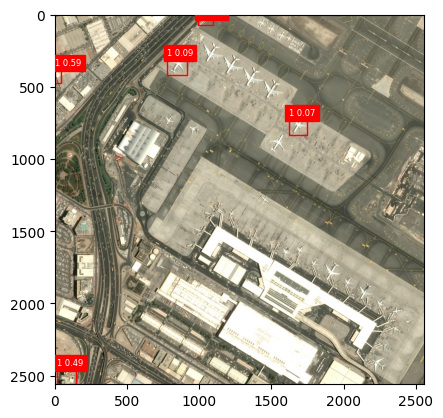

In [99]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Assuming 'image' is your original image tensor used for prediction
# Convert tensor image back to PIL for visualization
image_pil = F.to_pil_image(image.squeeze(0))  # Remove batch dimension

# Create a figure and axis for plotting
fig, ax = plt.subplots(1)
ax.imshow(image_pil)

# Assuming 'prediction' is the output from your model
prediction = prediction[0]  # Get predictions for the first image in the batch

# Set a threshold to only display predictions with a confidence above this value
threshold = 0

for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
    if score > threshold:
        # Convert to numpy, box format is [x0, y0, x1, y1]
        box = box.cpu().numpy()

        # Create a Rectangle patch
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                 linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Optional: Add label and score to the bounding box
        ax.text(box[0], box[1], f'{label.cpu().numpy()} {score:.2f}', color='white',
                backgroundcolor='red', fontsize=6, clip_on=True)

plt.show()
